In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
def scale_data(data):
    num_features = data.shape[1]
    scale_params = np.zeros((num_features,2))
    mins = np.min(data, axis=0);maxes=np.max(data, axis=0)
    data = (data - mins) / (maxes - mins)
    return data, scale_params

data_df = pd.read_csv("data/final_dataset.csv")

data_df = data_df.drop(['Date'], axis=1)
data_df = data_df.iloc[1900:,:]
data = np.nan_to_num(np.array(data_df, dtype=np.float32))
print(np.isnan(data).any().item())
data, scale_params = scale_data(data)
print(np.isnan(data).any().item())
data, scale_params = scale_data(np.nan_to_num(np.array(data_df, dtype=np.float32)))
print(data_df.head())

# print(data.shape)

False
False
         Open     High      Low    Close      MACD        ATR        RSI  \
1900  1283.21  1287.50  1256.98  1276.60 -4.820419  35.887857  30.130064   
1901  1302.22  1330.74  1277.16  1330.74 -2.159744  32.133571  41.043854   
1902  1334.63  1341.51  1298.42  1298.42 -3.087302  29.425714  33.795734   
1903  1299.67  1330.67  1295.22  1329.51 -0.866801  27.663571  39.512096   
1904  1333.66  1359.68  1330.29  1349.88 -0.276945  26.217143  55.488315   

      EFFR        VIX       USDX  UNRATE  UMCSENT  
1900  2.69  32.240002  71.459999     5.1     69.5  
1901  2.16  25.790001  71.570000     5.1     69.5  
1902  2.08  29.840000  72.139999     5.1     69.5  
1903  2.22  26.620001  72.750000     5.1     69.5  
1904  2.08  25.730000  72.949997     5.1     69.5  


In [12]:
print(data)
print(data.shape)
print(data_df)

[[0.14725697 0.14362836 0.14348508 ... 0.6262378  0.34693876 0.6854043 ]
 [0.15186056 0.15411496 0.14839119 ... 0.6272018  0.34693876 0.6854043 ]
 [0.15970922 0.15672693 0.15355985 ... 0.632197   0.34693876 0.6854043 ]
 ...
 [0.8933593  0.90284836 0.89626205 ... 0.         0.         0.        ]
 [0.9036539  0.9037529  0.9061034  ... 0.         0.         0.        ]
 [0.9163217  0.9248305  0.92194253 ... 0.         0.         0.        ]]
         Open     High      Low    Close       MACD        ATR        RSI  \
1900  1283.21  1287.50  1256.98  1276.60  -4.820419  35.887857  30.130064   
1901  1302.22  1330.74  1277.16  1330.74  -2.159744  32.133571  41.043854   
1902  1334.63  1341.51  1298.42  1298.42  -3.087302  29.425714  33.795734   
1903  1299.67  1330.67  1295.22  1329.51  -0.866801  27.663571  39.512096   
1904  1333.66  1359.68  1330.29  1349.88  -0.276945  26.217143  55.488315   
...       ...      ...      ...      ...        ...        ...        ...   
5840  4384.37  43

In [3]:
def create_sequence(data,seq_len):
    xs = []
    ys = []
    for i in range(len(data)-seq_len-1):
        x = data[i:(i+seq_len),:]
        # print(x.shape)
        y = data[i+seq_len,0]
        xs.append(x)
        ys.append(y)
    return np.array(xs),np.array(ys)

SEQ_LEN = 8
inputs , targets = create_sequence(data,SEQ_LEN)

inputs=torch.from_numpy(inputs);targets=torch.from_numpy(targets)

# split the input data into train and test data
train_size = int(0.8 * len(inputs))
test_size = len(inputs) - train_size
train_inputs, test_inputs = inputs[:train_size], inputs[train_size:]
train_targets, test_targets = targets[:train_size], targets[train_size:]
print(train_inputs.shape, test_inputs.shape)

torch.Size([3148, 8, 12]) torch.Size([788, 8, 12])


In [4]:

class PricePredictor(nn.Module):
    def __init__(self, input_size=12, hidden_layer_size=150, time_segment=5, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.time_segment_length = time_segment
        self.lstm = nn.LSTM(input_size, hidden_layer_size,batch_first=True) # N x L x input_size(12)
        self.linear = nn.Linear(hidden_layer_size, output_size) # N x L x output_size(1)
        self.ReLU = nn.ReLU()
        self.cell_double = None

    def forward(self, input_seq):
        '''
            input : N x L x input_size
            ouput : N x output_size
        '''
        output,_ = self.lstm(input_seq) # N x L x hidden_layer_size
        output = self.ReLU(output)
        predictions = self.linear(output[:,-1,:].squeeze()) # N x output_size
        return predictions, output[:,-1,:].squeeze()


In [5]:
class QLearningModel(nn.Module):
    def __init__(self, hidden_layer_size, num_actions):
        super(QLearningModel, self).__init__()
        self.fc = nn.Linear(hidden_layer_size, num_actions)

    def forward(self, hidden_state):
        return self.fc(hidden_state)

In [6]:
BATCH_SIZE = 16 
print(train_inputs.shape,train_targets.shape)
print(test_inputs.shape,test_targets.shape)
train_dataset = TensorDataset(train_inputs, train_targets)
test_dataset = TensorDataset(test_inputs, test_targets)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)



torch.Size([3148, 8, 12]) torch.Size([3148])
torch.Size([788, 8, 12]) torch.Size([788])


In [7]:
def test_dataloaders(train_dataset,test_dataset,num_itr = 10):
    for i, (inputs, targets) in enumerate(train_loader):
        print("train itr",inputs.shape, targets.shape)
        if i >= num_itr:
            break
    for i, (inputs, targets) in enumerate(test_loader):
        print("test_itr",inputs.shape, targets.shape)
        if i >= num_itr:
            break
# test_dataloaders(train_dataset,test_dataset)

In [9]:



def calculate_reward(action, current_price, previous_price, holding_status, transaction_cost=0.00):
    """
    Calculate the reward for an action.
    
    :param action: The action taken by the agent (0: Hold, 1: Buy, 2: Sell)
    :param current_price: Current stock price.
    :param previous_price: Previous stock price.
    :param holding_status: Whether the agent is currently holding a stock (1) or not (0).
    :param transaction_cost: Cost of making a transaction, as a percentage of trade value.
    
    :return: Calculated reward.
    """
    if action == 1:  # Buy
        if holding_status == 0:  # If not already holding
            reward = -transaction_cost  # Pay transaction cost
            holding_status = 1  # Update holding status
        else:
            reward = 0  # No action taken, no reward

    elif action == 2:  # Sell
        if holding_status == 1:  # If holding a stock
            profit = current_price - previous_price
            reward = profit - (transaction_cost * current_price)  # Gain from selling minus transaction cost
            holding_status = 0  # Update holding status
        else:
            reward = 0  # No action taken, no reward

    else:  # Hold
        if holding_status == 1:  # If holding a stock
            reward = current_price - previous_price  # Unrealized gain/loss
        else:
            reward = 0  # No stock held, no reward

    return reward, holding_status

In [10]:

model = PricePredictor()
ql_model = QLearningModel(hidden_layer_size=150, num_actions=3)  # 3 actions: Buy, Sell, Hold
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)
ql_optimizer = torch.optim.Adam(ql_model.parameters(), lr=0.001)

epochs = 30
holding_status = 0
for i in range(epochs):
    for seq, targets in train_loader:

        # seq, targets = seq.to(device), targets.to(device)
        price_predictions, hidden_states = model(seq)
        q_values = ql_model(hidden_states)
        actions = torch.argmax(q_values, dim=1)
        rewards = torch.Tensor(size=len(actions))
        for j in range(len(actions)):
            rewards[j], holding_status[j] = calculate_reward(actions[j], price_predictions[j], targets[j], holding_status[j], transaction_cost=0.00)
        optimizer.zero_grad()
        loss = loss_function(price_predictions, targets)
        loss.backward()
        optimizer.step()
        ql_optimizer.zero_grad()
        # ql_loss = torch.tensor(rewards).to(device)  # Placeholder for actual Q-learning loss calculation
        ql_loss = torch.tensor(rewards)  # Placeholder for actual Q-learning loss calculation
        ql_loss.backward()
        ql_optimizer.step()


    if(i%5==0):
        # print the test loss
        with torch.no_grad():
            test_loss_ = 0
            test_reward_ = 0
            for seq_, targets_ in test_loader:
                y_pred_test, hidden_states_ = model(seq_)
                q_values_ = ql_model(hidden_states_)
                test_loss_ += loss_function(y_pred_test, targets_)
                test_reward_ += torch.tensor(rewards)

                # print(y_pred_test.shape)
            print(f'Test loss: {test_loss_.item():10.8f}')
            print(f'Test loss: {test_reward_.item():10.8f}')
    

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

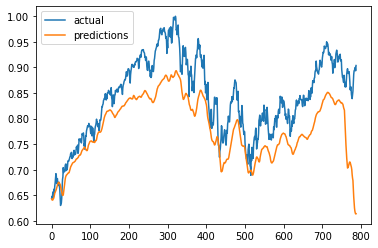

In [ ]:
actual_prices = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for seq, targets in test_loader:
        y_pred = model(seq)
        actual_prices.extend(targets.flatten())
        predictions.extend(y_pred.flatten())


actual_prices = np.array(actual_prices)
predictions = np.array(predictions)
x = np.arange(len(actual_prices))

plt.plot(x,actual_prices, label="actual")
plt.plot(x,predictions, label="predictions")
plt.legend()
plt.show()
